In [44]:
#coding:utf-8
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
import matplotlib.pyplot as plt
# %matplotlib inline

In [45]:
data_train = pd.read_csv("data/train.csv")

In [46]:
data_train.info()
data_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 一. 数据初步分析
认识数据

1.乘客各属性分布

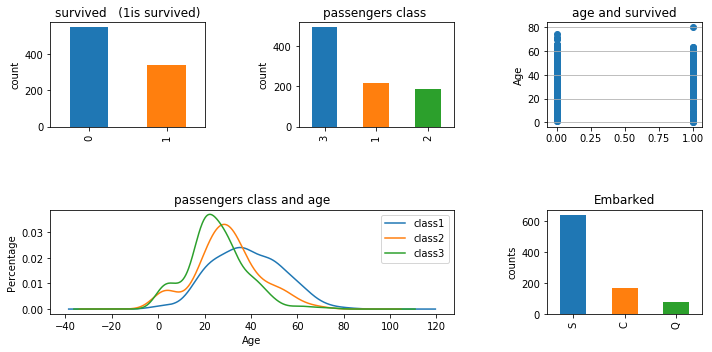

In [30]:
fig = plt.figure(figsize=(10,5))
fig.set(alpha=0.2)

#1.1 幸存人数
plt.subplot2grid((2,3),(0,0))
data_train.Survived.value_counts().plot(kind='bar')
plt.title("survived   (1is survived)")
plt.ylabel("count")

#1.2 乘客等级分布
plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel("count")
plt.title("passengers class ")

#1.3 按年龄看获救分布
plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel("Age")                         
plt.grid(b=True, which='major', axis='y') 
plt.title("age and survived")

#1.4 各等级的乘客年龄分布
plt.subplot2grid((2,3),(1,0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")
plt.ylabel("Percentage") 
plt.title("passengers class and age")
plt.legend(('class1', 'class2','class3'),loc='best')

# 1.5 各登船口岸上船人数
plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title("Embarked")
plt.ylabel("counts")  

fig.tight_layout(w_pad=5,h_pad=5) #adjust subplot


2.属性与获救结果的关联统计

Text(0,0.5,u'count')

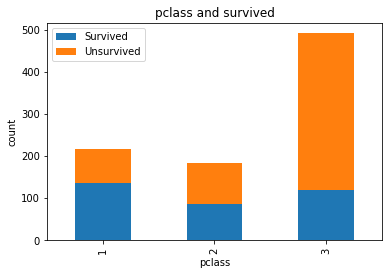

In [31]:
#2.1 乘客等级与获救情况
fig = plt.figure()
fig.set(alpha=0.2) 

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df=pd.DataFrame({'Survived':Survived_1, 'Unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title("pclass and survived")
plt.xlabel("pclass") 
plt.ylabel("count")


Text(0,0.5,u'count')

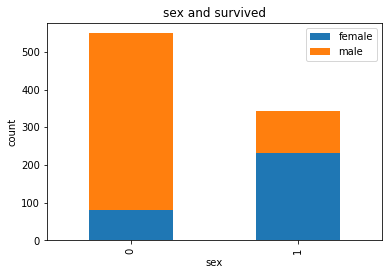

In [32]:
#2.2 性别与获救情况
fig = plt.figure()
fig.set(alpha=0.2)

Survived_m = data_train.Survived[data_train.Sex == 'male'].value_counts()
Survived_f = data_train.Survived[data_train.Sex == 'female'].value_counts()
df=pd.DataFrame({'male':Survived_m, 'female':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title("sex and survived")
plt.xlabel("sex") 
plt.ylabel("count")


Text(0,0.5,u'counts')

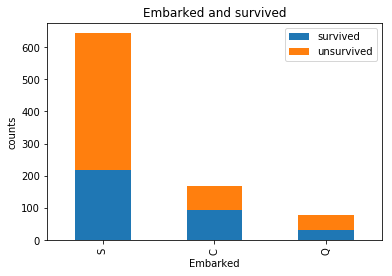

In [33]:
#2.3 登船港口与获救情况
fig = plt.figure()
fig.set(alpha=0.2)

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df=pd.DataFrame({'survived':Survived_1, 'unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title("Embarked and survived")
plt.xlabel("Embarked") 
plt.ylabel("counts")

In [34]:
#2.4 堂兄弟/妹，孩子/父母有几人，对是否获救的影响
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
print (df)

g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
print (df)




                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7
                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7


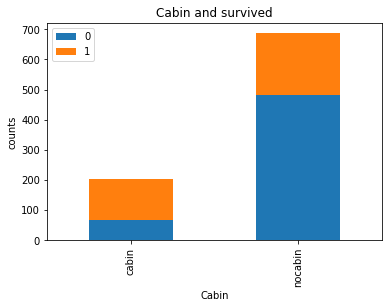

In [35]:
#2.5 Cabin和获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survived_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df=pd.DataFrame({'cabin':Survived_cabin, 'nocabin':Survived_nocabin}).transpose()
df.plot(kind='bar', stacked=True)
plt.title("Cabin and survived")
plt.xlabel("Cabin") 
plt.ylabel("counts")
plt.show()

# 二 数据预处理


# 1.缺值情况处理

1.1 缺值的样本占总数比例极高，直接舍弃

1.2 缺值的样本适中，而该属性非连续值特征属性(比如说类目属性)，那就把NaN作为一个新类别，加到类别特征中

1.3 如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它离散化，之后把NaN作为一个type加到属性类目中。

1.4 缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据
本例中，使用RandomForest模型拟合缺失的年龄数据

In [36]:
from sklearn.ensemble import RandomForestRegressor

### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])

    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

# 2. 特征因子化
数值型特征

In [37]:
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.000000,1,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,2,1,38.000000,1,0,71.2833,0,1,1,0,0,1,0,1,0,0
2,3,1,26.000000,0,0,7.9250,1,0,0,0,1,1,0,0,0,1
3,4,1,35.000000,1,0,53.1000,0,1,0,0,1,1,0,1,0,0
4,5,0,35.000000,0,0,8.0500,1,0,0,0,1,0,1,0,0,1
5,6,0,23.838953,0,0,8.4583,1,0,0,1,0,0,1,0,0,1
6,7,0,54.000000,0,0,51.8625,0,1,0,0,1,0,1,1,0,0
7,8,0,2.000000,3,1,21.0750,1,0,0,0,1,0,1,0,0,1
8,9,1,27.000000,0,2,11.1333,1,0,0,0,1,1,0,0,0,1
9,10,1,14.000000,1,0,30.0708,1,0,1,0,0,1,0,0,1,0


# 3.scaling标准化
加速收敛，将一些变化幅度较大的特征化到[-1,1]之内

In [38]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'])
df['Age_scaled'] = scaler.fit_transform(df['Age'], age_scale_param)
fare_scale_param = scaler.fit(df['Fare'])
df['Fare_scaled'] = scaler.fit_transform(df['Fare'], fare_scale_param)


ValueError: Expected 2D array, got 1D array instead:
array=[22.         38.         26.         35.         35.         23.83895259
 54.          2.         27.         14.          4.         58.
 20.         39.         14.         55.          2.         32.06649305
 31.         29.51820514 35.         34.         15.         28.
  8.         38.         29.51820514 19.         22.38011324 27.94720616
 40.         36.10804822 35.2958243  66.         28.         42.
 22.87630686 21.         18.         14.         40.         27.
 27.94720616  3.         19.         30.70572678 33.12898535 35.2958243
 23.45968333 18.          7.         21.         49.         29.
 65.         44.06483036 21.         28.5         5.         11.
 22.         38.         45.          4.         41.20008848 17.09991595
 29.         19.         17.         26.         32.         16.
 21.         26.         32.         25.         27.94720616 30.70572678
  0.83       30.         22.         29.         23.32262739 28.
 17.         33.         16.         30.70572678 23.         24.
 29.         20.         46.         26.         59.         30.70572678
 71.         23.         34.         34.         28.         27.94720616
 21.         33.         37.         28.         21.         27.51545426
 38.         33.55117591 47.         14.5        22.         20.
 17.         21.         70.5        29.         24.          2.
 21.         30.70572678 32.5        32.5        54.         12.
 35.2958243  24.         25.78337698 45.         33.         20.
 47.         29.         25.         23.         19.         37.
 16.         24.         25.34409583 22.         24.         19.
 18.         19.         27.          9.         36.5        42.
 51.         22.         55.5        40.5        29.78279613 51.
 16.         30.         25.52340334 10.86986696 44.         40.
 26.         17.          1.          9.         26.03188214 45.
 49.5542756  28.         61.          4.          1.         21.
 56.         18.          7.30954704 50.         30.         36.
 10.86986696 31.71894048  9.          1.          4.         46.24976824
 33.12898535 45.         40.         36.         32.         19.
 19.          3.         44.         58.         35.2958243  42.
 35.2958243  24.         28.         10.86986696 34.         45.5
 18.          2.         32.         26.         16.         40.
 24.         35.         22.         30.         31.09342985 31.
 27.         42.         32.         30.         16.         27.
 51.         27.94720616 38.         22.         19.         20.5
 18.          7.30954704 35.         29.         59.          5.
 24.         31.10838452 44.          8.         19.         33.
 20.80015413 33.12898535 29.         22.         30.         44.
 25.         24.         37.         54.         29.78279613 29.
 62.         30.         41.         29.         34.62028571 30.
 35.         50.         35.2958243   3.         52.         40.
 35.2958243  36.         16.         25.         58.         35.
 36.87489821 25.         41.         37.         35.2958243  63.
 45.         35.05181757  7.         35.         65.         28.
 16.         19.         57.74249226 33.         30.         22.
 42.         22.         26.         19.         36.         24.
 24.         41.20008848 23.5         2.         41.57487718 50.
 35.2958243  23.31368333 19.         42.57451554 30.70572678  0.92
 28.57888393 17.         30.         30.         24.         18.
 26.         28.         43.         26.         24.         54.
 31.         40.         22.         27.         30.         22.
 10.86986696 36.         61.         36.         31.         16.
 23.31368333 45.5        38.         16.         31.42587794 27.94720616
 29.         41.         45.         45.          2.         24.
 28.         25.         36.         24.         40.         26.68916849
  3.         42.         23.         59.96916448 15.         25.
 29.51820514 28.         22.         38.         22.38011324 22.38011324
 40.         29.         45.         35.         33.12898535 30.
 60.         22.87630686 35.2958243  24.         25.         18.
 19.         22.          3.         31.94479345 22.         27.
 20.         19.         42.          1.         32.         35.
 27.94720616 18.          1.         36.         19.89558113 17.
 36.         21.         28.         23.         24.         22.
 31.         46.         23.         28.         39.         26.
 21.         28.         20.         34.         51.          3.
 21.          7.30954704 27.94720616 20.68131488 33.         35.05181757
 44.         30.70572678 34.         18.         30.         10.
 27.94720616 21.         29.         28.         18.         29.78279613
 28.         19.         35.2958243  32.         28.         26.68916849
 42.         17.         50.         14.         21.         24.
 64.         31.         45.         20.         25.         28.
 23.47643239  4.         13.         34.          5.         52.
 36.         24.10899881 30.         49.         30.70572678 29.
 65.         44.06001827 50.         35.2958243  48.         34.
 47.         48.         30.70572678 38.         35.05181757 56.
 19.89558113  0.75       29.78279613 38.         33.         23.
 22.         44.65953056 34.         29.         22.          2.
  9.         35.05181757 50.         63.         25.          7.30954704
 35.         58.         30.          9.         24.10899881 21.
 55.         71.         21.         18.19479484 54.         25.7554753
 25.         24.         17.         21.         26.82073281 37.
 16.         18.         33.         49.8994093  28.         26.
 29.         30.70572678 36.         54.         24.         47.
 34.         34.17374861 36.         32.         30.         22.
 29.51820514 44.         22.87630686 40.5        50.         38.5155
 39.         23.          2.         22.87630686 17.          8.01370298
 30.          7.         45.         30.         24.33021696 22.
 36.          9.         11.         32.         50.         64.
 19.         32.79502428 33.          8.         17.         27.
 26.3814249  22.         22.         62.         48.         38.5155
 39.         36.         35.2958243  40.         28.         30.70572678
 30.70572678 24.         19.         29.         22.87630686 32.
 62.         53.         36.         35.2958243  16.         19.
 34.         39.         20.07016773 32.         25.         39.
 54.         36.         29.04293865 18.         47.         60.
 22.         30.70572678 35.         52.         47.         27.45639428
 37.         36.         24.40235514 49.         29.51820514 49.
 24.         27.94720616 37.51615833 44.         35.         36.
 30.         27.         22.         40.         39.         27.86873699
 33.12898535 35.2958243  35.         24.         34.         26.
  4.         26.         27.         42.         20.         21.
 21.         61.         57.         21.         26.         19.89558113
 80.         51.         32.         38.83477484  9.         28.
 32.         31.         41.         26.68916849 20.         24.
  2.         29.56889809  0.75       48.         19.         56.
 31.10838452 23.         27.94720616 18.         21.         26.3814249
 18.         24.         27.94720616 32.         23.         58.
 50.         40.         47.         36.         20.         32.
 25.         27.51545426 43.         39.08817814 40.         31.
 70.         31.         35.05181757 18.         24.5        18.
 43.         36.         23.47643239 27.         20.         14.
 60.         25.         14.         19.         18.         15.
 31.          4.         29.56889809 25.         60.         52.
 44.         19.89558113 49.         42.         18.         35.
 18.         25.         26.         39.         45.         42.
 22.         17.09991595 24.         49.8994093  48.         29.
 52.         19.         38.         27.         27.30887391 33.
  6.         17.         34.         50.         27.         20.
 30.         19.89558113 25.         25.         29.         11.
 35.05181757 23.         23.         28.5        48.         35.
 27.94720616 27.94720616 38.42663175 36.         21.         24.
 31.         70.         16.         30.         19.         31.
  4.          6.         33.         23.         48.          0.67
 28.         18.         34.         33.         24.33021696 41.
 20.         36.         16.         51.         39.17490238 30.5
 33.55117591 32.         24.         48.         57.         29.51820514
 54.         18.         35.2958243   5.         19.89558113 43.
 13.         17.         29.         16.1939502  25.         25.
 18.          8.          1.         46.         35.2958243  16.
 10.86986696 50.38328427 25.         39.         49.         31.
 30.         30.         34.         31.         11.          0.42
 27.         31.         39.         18.         39.         33.
 26.         39.         35.          6.         30.5        38.83477484
 23.         31.         43.         10.         52.         27.
 38.         27.          2.         35.09787898 29.56889809  1.
 35.2958243  62.         15.          0.83       22.87630686 23.
 18.         39.         21.         30.70572678 32.         50.91095013
 20.         16.         30.         34.5        17.         42.
 10.86986696 35.         28.         43.96476448  4.         74.
  9.         16.         44.         18.         45.         51.
 24.         22.87630686 41.         21.         48.         10.86986696
 24.         42.         27.         31.         25.97788916  4.
 26.         47.         33.         47.         28.         15.
 20.         19.         27.94720616 56.         25.         33.
 22.         28.         25.         39.         27.         19.
 16.1939502  26.         32.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# 分析思路

先做出来一个baseline的model，再进行后续的优化。

优化要点：

1.分析model现在的状态(欠/过拟合)，

2.分析使用的feature，进行feature selection，

3.模型下的bad case和产生的原因

# 3.1 逻辑回归建模---baseline model

In [39]:
from sklearn import linear_model

# 用正则取出我们要的属性值
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [40]:
#将test_data”做和”train_data”一样的预处理
data_test = pd.read_csv("data/test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0

# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()

# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'], age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'], fare_scale_param)
df_test

NameError: name 'age_scale_param' is not defined

In [41]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("data/logistic_regression_predictions.csv", index=False)

In [47]:
pd.read_csv("data/logistic_regression_predictions.csv")

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# 3.2 逻辑回归系统优化

1. 判定一下当前模型所处状态(欠拟合or过拟合)
过拟合
做一下feature selection，挑出较好的feature的subset来做training
提供更多的数据，从而弥补原始数据的bias问题，学习到的model也会更准确 

In [49]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.learning_curve import learning_curve

# # 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
#                         train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
#     """
#     画出data在某模型上的learning curve.
#     参数解释
#     ----------
#     estimator : 你用的分类器。
#     title : 表格的标题。
#     X : 输入的feature，numpy类型
#     y : 输入的target vector
#     ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
#     cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
#     n_jobs : 并行的的任务数(默认1)
#     """
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     if plot:
#         plt.figure()
#         plt.title(title)
#         if ylim is not None:
#             plt.ylim(*ylim)
#         plt.xlabel(u"训练样本数")
#         plt.ylabel(u"得分")
#         plt.gca().invert_yaxis()
#         plt.grid()
    
#         plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
#                          alpha=0.1, color="b")
#         plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
#                          alpha=0.1, color="r")
#         plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
#         plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
#         plt.legend(loc="best")
        
#         plt.draw()
#         plt.gca().invert_yaxis()
#         plt.show()
    
#     midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
#     diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
#     return midpoint, diff

# plot_learning_curve(clf, u"学习曲线", X, y)

优化思想

年龄离散化，按区段分作类别属性会更合适一些

做交叉验证
cross validation：把train.csv分成两部分，一部分用于训练我们需要的模型，另外一部分数据上看我们预测算法的效果

In [51]:
#特征和获救率之间的关系
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

,coef,columns
0,[-0.20057932265802128],SibSp
1,[-0.05617458834188049],Parch
2,[-0.5915868756823762],Cabin_No
3,[0.35292444806968537],Cabin_Yes
4,[0.2004441916076527],Embarked_C
5,[0.0],Embarked_Q
6,[-0.3418629972825361],Embarked_S
7,[2.3646567708728337],Sex_female
8,[-0.2978833151134071],Sex_male
9,[0.0],Pclass_1


模型中权重绝对值非常大的feature：
sex,pclass,Age

S会很大程度拉低获救的概率，另外俩港口压根就没啥作用(这个实际上非常奇怪，因为我们从之前的统计图上并没有看到S港口的获救率非常低，所以也许可以考虑把登船港口这个feature去掉试试)。

Fare有小幅度的正相关,可以考虑离散化

哪些优化的方法是promising的呢？

In [58]:
# from sklearn import cross_validation

# # 简单看看打分情况
# clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# all_data = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# X = all_data.as_matrix()[:,1:]
# y = all_data.as_matrix()[:,0]
# print cross_validation.cross_val_score(clf, X, y, cv=5)


# # 分割数据
# split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
# train_df = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# # 生成模型
# clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# clf.fit(train_df.as_matrix()[:,1:], train_df.as_matrix()[:,0])



# # 对cross validation数据进行预测

# cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# predictions = clf.predict(cv_df.as_matrix()[:,1:])
# split_cv[ predictions != cv_df.as_matrix()[:,0] ].drop()

In [54]:
# 去除预测错误的case看原始dataframe数据
#split_cv['PredictResult'] = predictions
origin_data_train = pd.read_csv("Train.csv")
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases

对比bad case，我们仔细看看我们预测错的样本，到底是哪些特征有问题，咱们处理得还不够细？

我们随便列一些可能可以做的优化操作：

    Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
    Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
    Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
    Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
    单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
    如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
    登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
    把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
    Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。


In [59]:
data_train[data_train['Name'].str.contains("Major")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.50,C104,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.55,B38,S


In [64]:
data_train = pd.read_csv("train.csv")
data_train['Sex_Pclass'] = data_train.Sex + "_" + data_train.Pclass.map(str)

from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_train['Sex_Pclass'], prefix= 'Sex_Pclass')


df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass'], axis=1, inplace=True)
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df['Age'])
df['Age_scaled'] = scaler.fit_transform(df['Age'], age_scale_param)
fare_scale_param = scaler.fit(df['Fare'])
df['Fare_scaled'] = scaler.fit_transform(df['Fare'], fare_scale_param)

from sklearn import linear_model

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)
clf

In [66]:
data_test = pd.read_csv("test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
data_test['Sex_Pclass'] = data_test.Sex + "_" + data_test.Pclass.map(str)
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
dummies_Sex_Pclass = pd.get_dummies(data_test['Sex_Pclass'], prefix= 'Sex_Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, dummies_Sex_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Sex_Pclass'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'], age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'], fare_scale_param)
df_test

In [67]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions2.csv", index=False)

# 3.3 模型融合

In [69]:
from sklearn.ensemble import BaggingRegressor

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=10, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
predictions = bagging_clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("/Users/MLS/Downloads/logistic_regression_predictions2.csv", index=False)